In [43]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm)

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts

In [44]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [45]:
numpy.set_printoptions(linewidth = 200)

qubits = 5

# # should be "GHZ", "cascade", "dense", or "clustered"
# circuit_type = "GHZ"
# layers = 1 # number of gate layers

# qubits = 6 # number of qubits
# frag_num = 2 # number of fragments

simulation_backend = "qasm_simulator"

seed = 0
print_circuits = True

In [46]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2022-10-28 10:29:26,890: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [47]:
device = provider.get_backend('ibmq_guadalupe')
device

<IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>

In [48]:
noisy_simulator = provider.get_backend('ibmq_qasm_simulator')

In [49]:
front_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_front.qasm")

In [50]:
mid_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_mid.qasm")

In [51]:
end_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_end.qasm")

In [52]:
orign_circuit = front_layer + mid_layer + end_layer

In [53]:
#checking circuit

In [54]:
def apply_checking_circuit(qc, ctrl_bits, ancilla_bits, side = None):
    if len(ctrl_bits) != len(ancilla_bits):
        print("Size mismatch")
        return None
    if side == 'front':
        for i in ancilla_bits:
            qc.h(i)
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
    elif side == 'end':
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
        for i in ancilla_bits:
            qc.h(i)
    else:
        print("Side undefined")

In [55]:
circuit = front_layer.copy()

In [56]:
apply_checking_circuit(circuit, [1], [5], side = 'front')
circuit += mid_layer
apply_checking_circuit(circuit, [1], [5], side = 'end')
circuit += end_layer

In [57]:
circuit.draw()

┌────────────┐      ┌────────────┐                                    
q_0: ─┤ RY(-4.751) ├────■─┤ RY(4.6739) ├────────────────────────────────────
      ├────────────┤    │ └────────────┘      ┌─────────────┐               
q_1: ─┤ RY(3.1415) ├─■──■───────■───────────■─┤ RY(-3.1415) ├───────────────
     ┌┴────────────┤ │          │           │ └┬────────────┤               
q_2: ┤ RY(-3.8492) ├─┼──────────■────────■──┼──┤ RY(0.7076) ├───────────────
     ├─────────────┤ │                   │  │  └────────────┘ ┌────────────┐
q_3: ┤ RY(-3.1416) ├─┼───────────────────■──┼────────■────────┤ RY(3.1415) ├
     ├─────────────┤ │                      │        │       ┌┴────────────┤
q_4: ┤ RY(-6.8335) ├─┼──────────────────────┼────────■───────┤ RY(-3.6921) ├
     └────┬───┬────┘ │                      │      ┌───┐     └─────────────┘
q_5: ─────┤ H ├──────■──────────────────────■──────┤ H ├────────────────────
          └───┘                                    └───┘                    
q_6: ───────────────────────────────────────────────────────────────────────
                                                                            
q_7: ───────────────────────────────────────────────────────────────────────
                                                                            
q_8: ───────────────────────────────────────────────────────────────────────
                                                                            
q_9: ───────────────────────────────────────────────────────────────────────

In [58]:
trans_qc = transpile(circuit, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

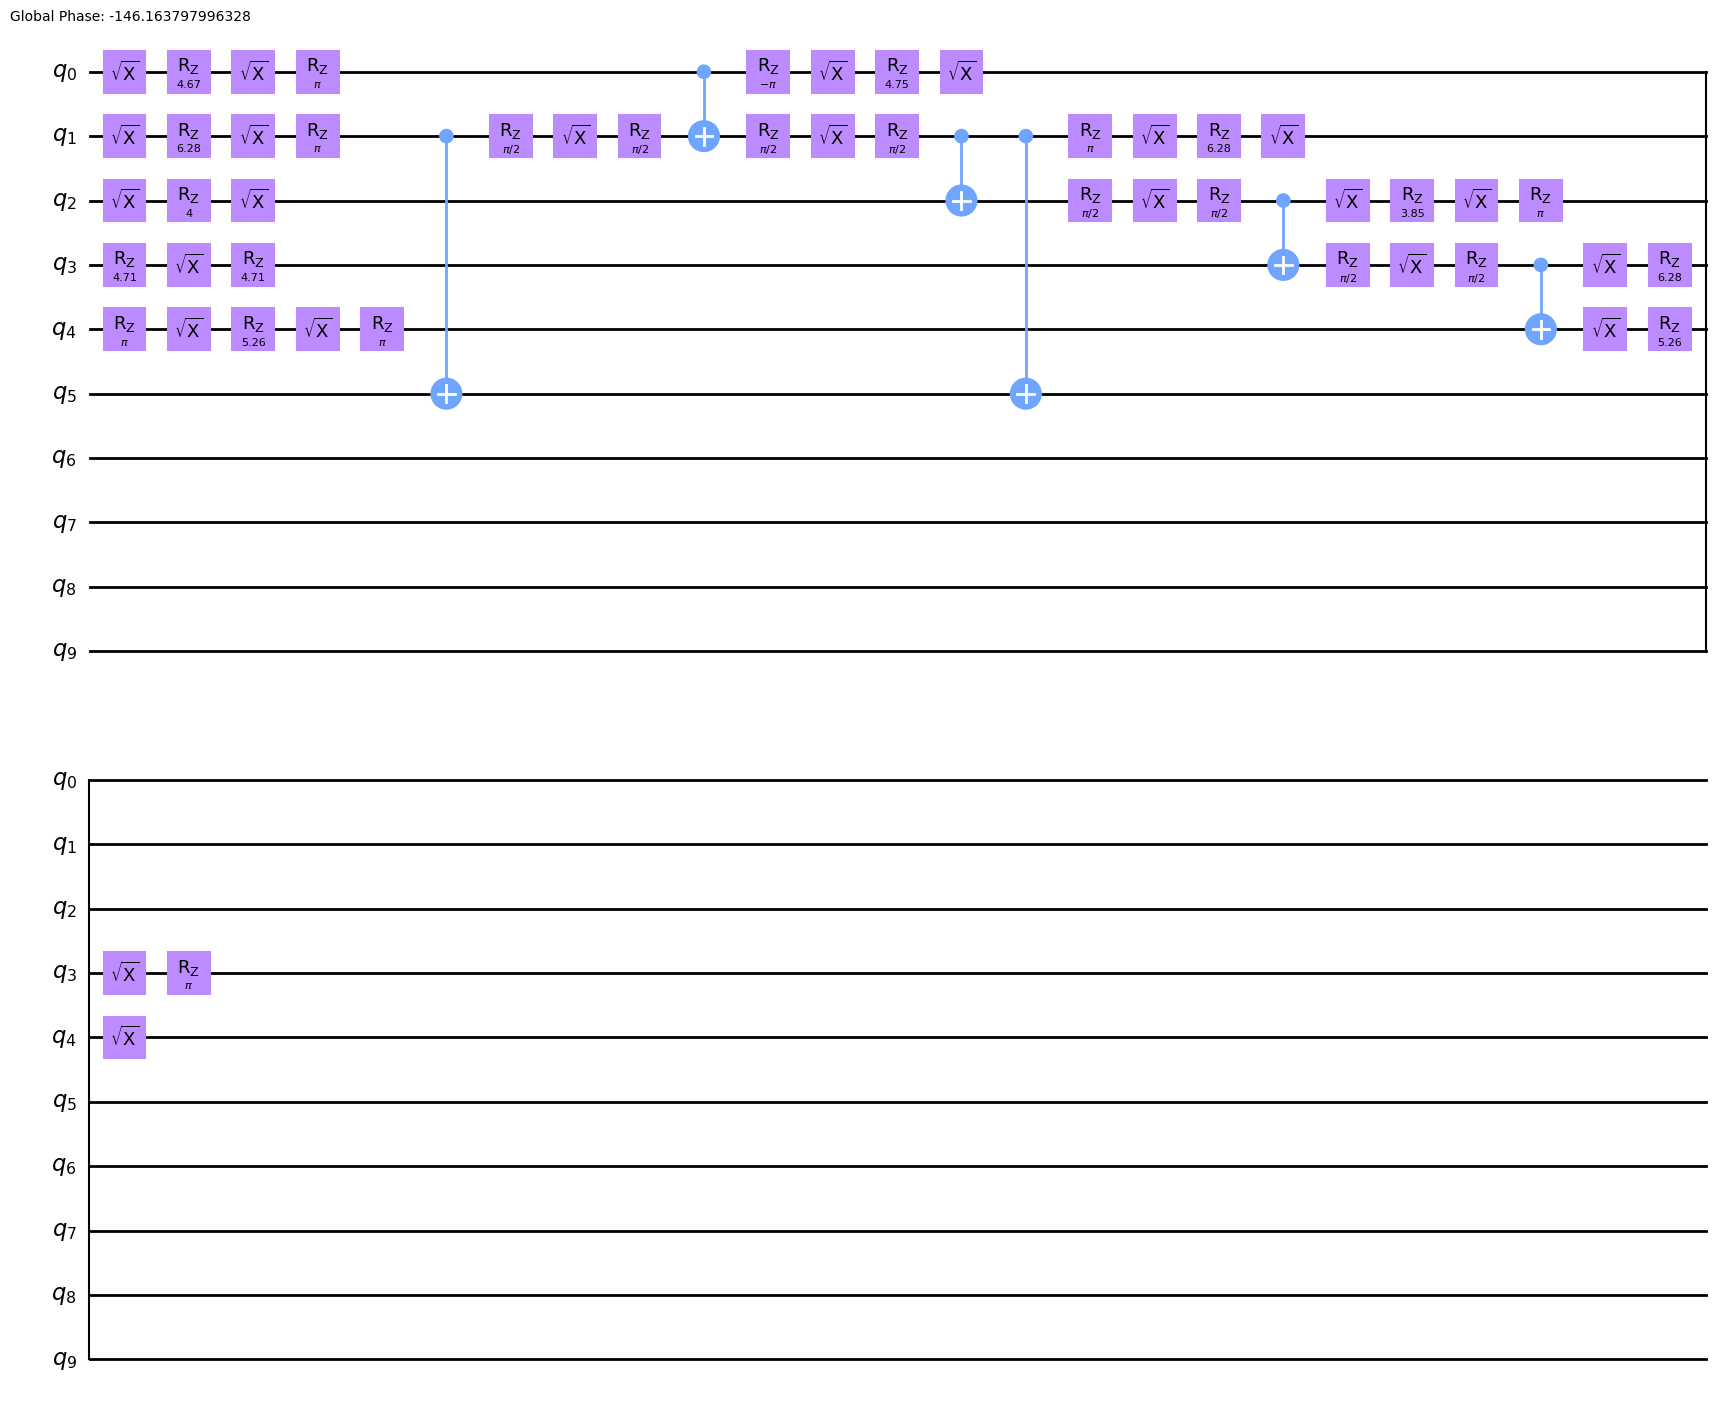

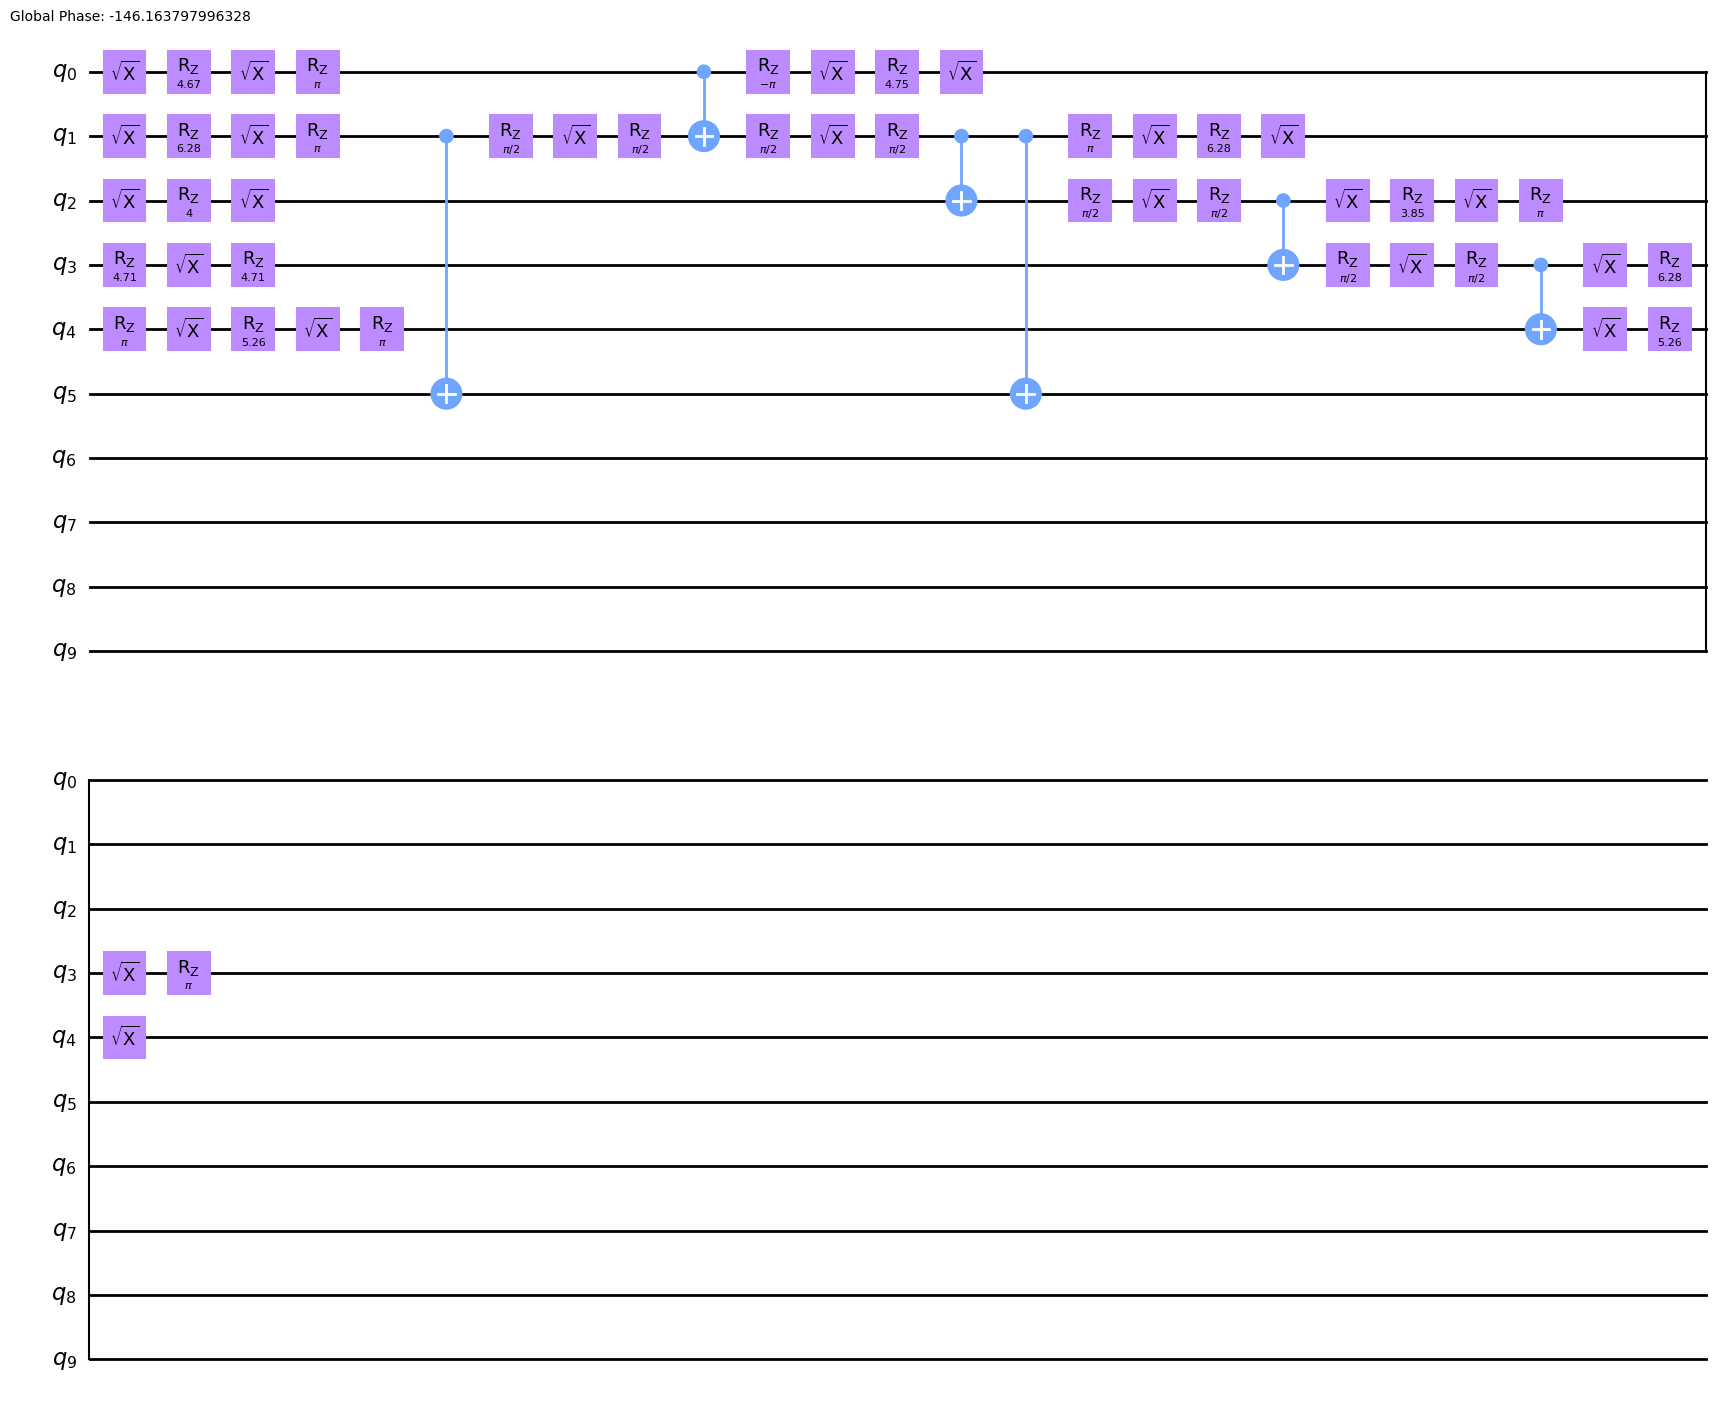

In [59]:
trans_qc.draw(output = 'mpl')

In [60]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device, gate_error = False, thermal_relaxation= False)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Specific qubit errors: [('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), ('measure', [7]), ('measure', [8]), ('measure', [9]), ('measure', [10]), ('measure', [11]), ('measure', [12]), ('measure', [13]), ('measure', [14]), ('measure', [15])]


In [61]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [62]:
# p_gate1 = 0.4
# error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

In [63]:
# noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

In [64]:
circuit = trans_qc

In [65]:
cuts = []
# for i in range(0, 5):
#     if i == 0:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 6)]
#     elif i == 3:
#         cut = [(circuit.qubits[i], 4),(circuit.qubits[i], 12)]
#     elif i == qubits-1:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 12)]
#     else:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 13)]
#     cuts += cut
cuts = [(circuit.qubits[1], 5),(circuit.qubits[1], 13)]

In [66]:
print(cuts)

[(Qubit(QuantumRegister(10, 'q'), 1), 5), (Qubit(QuantumRegister(10, 'q'), 1), 13)]


In [67]:
fragments, wire_path_map = circuit_cutter.cut_circuit(circuit, cuts)

unused qubits: [Qubit(QuantumRegister(10, 'q'), 6), Qubit(QuantumRegister(10, 'q'), 7), Qubit(QuantumRegister(10, 'q'), 8), Qubit(QuantumRegister(10, 'q'), 9)]


In [68]:
print(wire_path_map)

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 4)),), Qubit(QuantumRegister(10, 'q'), 1): ((1, Qubit(QuantumRegister(3, 'q'), 2)), (0, Qubit(QuantumRegister(5, 'q'), 3)), (1, Qubit(QuantumRegister(3, 'q'), 0))), Qubit(QuantumRegister(10, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 3): ((0, Qubit(QuantumRegister(5, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}


In [69]:
total_variants = ml.fragment_variants(wire_path_map)

In [70]:
total_variants

25

In [71]:
shots = 32000 * total_variants

In [72]:
if print_circuits:
    print("total circuit:")
    print(circuit)
    print("cuts:")
    for cut in cuts:
        print("",cut)
    print()
    for idx, fragment in enumerate(fragments):
        print(f"fragment {idx}:")
        print(fragment)
        print()
    fragment_cuts = ml.fragment_cuts(wire_path_map)
    print("fragment_index, prep_cuts, meas_cuts:")
    for frag_idx, frag_cuts in enumerate(fragment_cuts):
        print(frag_idx, frag_cuts["prep"], frag_cuts["meas"])
    print()
    print("total number of fragment variants:", total_variants)
    print("total number of shots:", ( shots // total_variants ) * total_variants)
    print()

total circuit:
global phase: -146.163797996328
         ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐              »
q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├──────────────»
         ├────┤    ├────────────┤    ├────┤    ├───────┤              »
q_1: ────┤ √X ├────┤ RZ(6.2831) ├────┤ √X ├────┤ RZ(π) ├───────────■──»
         ├────┤    ├────────────┤    ├────┤    └───────┘           │  »
q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├────────────────────────┼──»
     ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐                    │  »
q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├────────────────────┼──»
     └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐  │  »
q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├──┼──»
       └───────┘       └────┘    └────────────┘  └────┘ └───────┘┌─┴─┐»
q_5: ────────────────────────────────────────────────────────────┤ X ├»
                                                                 └───┘»
q_6: ────────────

In [73]:
print(fragment_cuts)

[{'prep': 1, 'meas': 1}, {'prep': 1, 'meas': 1}, {'prep': 0, 'meas': 0}]


In [74]:
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [75]:
print(all_bits)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [76]:
# # get the actual state / probability distribution for the full circuit
# actual_state = ml.get_statevector(circuit)
# actual_dist = { "".join(bits) : abs(amp)**2
#                 for bits, amp in zip(all_bits, actual_state)
#                 if amp != 0 }

# # get a simulated probability distribution for the full circuit
# circuit.measure_active()
# full_circuit_result = ml.run_circuits(circuit, shots, backend = simulation_backend)
# full_circuit_dist = {}
# for part in full_circuit_result:
#     for bits, counts in part.get_counts(circuit).items():
#         if bits not in full_circuit_dist:
#             full_circuit_dist[bits] = 0
#         full_circuit_dist[bits] += counts / shots

In [77]:
wire_path_map

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 4)),),
 Qubit(QuantumRegister(10, 'q'), 1): ((1, Qubit(QuantumRegister(3, 'q'), 2)),
  (0, Qubit(QuantumRegister(5, 'q'), 3)),
  (1, Qubit(QuantumRegister(3, 'q'), 0))),
 Qubit(QuantumRegister(10, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 3): ((0, Qubit(QuantumRegister(5, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}

In [78]:
orign_qc = QuantumCircuit.from_qasm_file("qasm/vqe_5q.qasm")
orign_qc.measure_all()

In [79]:
orign_qc = transpile(orign_qc, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

In [80]:
orign_qc.draw()

global phase: -110.035482480046
            ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐          ┌────────┐»
   q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
            ├────┤    ├────────────┤    ├────┤    └───────┘  ┌─┴─┐  ┌┴────────┤»
   q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├───────────────┤ X ├──┤ RZ(π/2) ├»
            ├────┤    ├────────────┤    ├────┤               └───┘  └─────────┘»
   q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├─────────────────────────────────»
        ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐                             »
   q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├─────────────────────────────»
        └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐           »
   q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├───────────»
          └───────┘       └────┘    └────────────┘  └────┘ └───────┘           »
meas: 5/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌────┐┌────────────┐┌────┐                                     »
«   q_0: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├─────────────────────────────────────»
«        ├────┤└┬─────────┬─┘└────┘ ┌───────┐ ┌────┐┌────────────┐┌────┐»
«   q_1: ┤ √X ├─┤ RZ(π/2) ├────■────┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├»
«        └────┘ └─────────┘  ┌─┴─┐ ┌┴───────┴┐├────┤└┬─────────┬─┘└────┘»
«   q_2: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■───»
«                            └───┘ └─────────┘└────┘ └─────────┘  ┌─┴─┐ »
«   q_3: ─────────────────────────────────────────────────────────┤ X ├─»
«                                                                 └───┘ »
«   q_4: ───────────────────────────────────────────────────────────────»
«                                                                       »
«meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                         »
«   q_0: ─────────────────────────────────────────────────────────────────»
«                                                                         »
«   q_1: ─────────────────────────────────────────────────────────────────»
«           ┌────┐  ┌────────────┐   ┌────┐  ┌───────┐                    »
«   q_2: ───┤ √X ├──┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├────────────────────»
«        ┌──┴────┴─┐└───┬────┬───┘┌──┴────┴─┐└───────┘┌────┐┌────────────┐»
«   q_3: ┤ RZ(π/2) ├────┤ √X ├────┤ RZ(π/2) ├────■────┤ √X ├┤ RZ(6.2831) ├»
«        └─────────┘    └────┘    └─────────┘  ┌─┴─┐  ├────┤├────────────┤»
«   q_4: ──────────────────────────────────────┤ X ├──┤ √X ├┤ RZ(5.2629) ├»
«                                              └───┘  └────┘└────────────┘»
«meas: 5/═════════════════════════════════════════════════════════════════»
«                                                                         »
«                        ░ ┌─┐            
«   q_0: ────────────────░─┤M├────────────
«                        ░ └╥┘┌─┐         
«   q_1: ────────────────░──╫─┤M├─────────
«                        ░  ║ └╥┘┌─┐      
«   q_2: ────────────────░──╫──╫─┤M├──────
«        ┌────┐┌───────┐ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤ √X ├┤ RZ(π) ├─░──╫──╫──╫─┤M├───
«        ├────┤└───────┘ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤ √X ├──────────░──╫──╫──╫──╫─┤M├
«        └────┘          ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

In [81]:
len(fragments)

3

In [82]:
temp_frag_data = [0] * len(fragments)

In [83]:
fragments[0].draw()

┌────────────┐    ┌────┐    ┌────────────┐                             »
q_0: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├─────────────────────────────»
     └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐           »
q_1: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├───────────»
       └─┬────┬┘   ┌───┴────┴───┐└───┬────┬───┘  └────┘ └───────┘           »
q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├─────────────────────────────────»
      ┌──┴────┴─┐  └───┬────┬───┘ ┌──┴────┴─┐             ┌───┐  ┌─────────┐»
q_3: ─┤ RZ(π/2) ├──────┤ √X ├─────┤ RZ(π/2) ├─────────────┤ X ├──┤ RZ(π/2) ├»
      └──┬────┬─┘  ┌───┴────┴───┐ └──┬────┬─┘  ┌───────┐  └─┬─┘  └┬────────┤»
q_4: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
         └────┘    └────────────┘    └────┘    └───────┘          └────────┘»
«                                                           ┌───┐┌─────────┐»
«q_0: ──────────────────────────────────────────────────────┤ X ├┤ RZ(π/2) ├»
«                                                           └─┬─┘└─────────┘»
«q_1: ────────────────────────────────────────────────────────┼─────────────»
«                         ┌───┐ ┌─────────┐┌────┐┌─────────┐  │     ┌────┐  »
«q_2: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├──■─────┤ √X ├──»
«     ┌────┐ ┌─────────┐  └─┬─┘ └─────────┘└────┘└─────────┘        └────┘  »
«q_3: ┤ √X ├─┤ RZ(π/2) ├────■───────────────────────────────────────────────»
«     ├────┤┌┴─────────┴─┐┌────┐                                            »
«q_4: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├────────────────────────────────────────────»
«     └────┘└────────────┘└────┘                                            »
«         ┌────┐    ┌─────────┐         ┌────┐┌────────────┐┌────┐┌───────┐
«q_0: ────┤ √X ├────┤ RZ(π/2) ├────■────┤ √X ├┤ RZ(6.2831) ├┤ √X ├┤ RZ(π) ├
«         └────┘    └─────────┘  ┌─┴─┐  ├────┤├────────────┤├────┤└───────┘
«q_1: ───────────────────────────┤ X ├──┤ √X ├┤ RZ(5.2629) ├┤ √X ├─────────
«     ┌────────────┐   ┌────┐  ┌─┴───┴─┐└────┘└────────────┘└────┘         
«q_2: ┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├───────────────────────────────────
«     └────────────┘   └────┘  └───────┘                                   
«q_3: ─────────────────────────────────────────────────────────────────────
«                                                                          
«q_4: ─────────────────────────────────────────────────────────────────────
«

In [84]:
for i in range(0, len(fragments)):
    if i == 0:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = device, opt_lvl = 3, extra_qc = [orign_qc])
    else:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = simulation_backend)

Job Status: job has successfully run
job_id:  635bf58a49bfe9cb99d1a23e
Job Status: job has successfully run
job_id:  635bf61149bfe96784d1a240
Job Status: job has successfully run
job_id:  635bf6530b130e21bf7f1af4
Job Status: job has successfully run
job_id:  635bf762332596723e2f5019
Job Status: job has successfully run
job_id:  9f0daeaf-99c1-426b-aaac-b7b23efe88e9
Job Status: job has successfully run
job_id:  7f7ffe22-d933-4d03-a68f-7e4800d816a4


In [85]:
temp_frag_data[0][0]

[Result(backend_name='ibmq_guadalupe', backend_version='1.3.29', qobj_id='a0ad8aa8-4cfd-4a02-8390-784e4f190e60', job_id='635bf58a49bfe9cb99d1a23e', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 747, '0x1': 15, '0x10': 70, '0x11': 19, '0x12': 239, '0x13': 26, '0x14': 91, '0x15': 55, '0x16': 305, '0x17': 81, '0x18': 4, '0x19': 5, '0x1a': 21, '0x1b': 8, '0x1c': 15, '0x1d': 3, '0x1e': 49, '0x1f': 2, '0x2': 2533, '0x3': 34, '0x4': 791, '0x5': 41, '0x6': 2806, '0x7': 102, '0x8': 10, '0x9': 3, '0xa': 44, '0xb': 10, '0xc': 7, '0xd': 6, '0xe': 45, '0xf': 5}), header=QobjExperimentHeader(clbit_labels=[['c1', 0], ['c1', 1], ['c1', 2], ['c1', 3], ['c1', 4]], creg_sizes=[['c1', 5]], global_phase=-0.8654297881037616, memory_slots=5, n_qubits=16, name="(('S0', 'S0', 'S0', 'S0', 'S0'), ('Z', 'Z', 'Z', 'Z', 'Z'))", qreg_sizes=[['q', 16]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6], ['q', 7

In [86]:
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [87]:
# for i in range(1, len(fragments)):
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [88]:
frag_targets = ml.identify_frag_targets(wire_path_map)

In [89]:
frag_data = []
for i in range(0, len(fragments)):
    extra_list = []
    if i == 0:
        extra_list = [orign_qc]
    frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
                                      frag_targets[i].get("prep"),
                                      frag_targets[i].get("meas"),
                                      prep_basis = "SIC", extra_qc = extra_list))

In [90]:
len(frag_data)

3

In [91]:
frag_data[1]

{'11': {(('S0',), ('Zm',)): 32000,
  (('S0',), ('Xp',)): 16031,
  (('S0',), ('Xm',)): 15969,
  (('S0',), ('Yp',)): 16151,
  (('S0',), ('Ym',)): 15849,
  (('S1',), ('Zm',)): 10668,
  (('S1',), ('Xp',)): 5450,
  (('S1',), ('Xm',)): 5279,
  (('S1',), ('Yp',)): 5308,
  (('S1',), ('Ym',)): 5333,
  (('S2',), ('Zm',)): 10796,
  (('S2',), ('Xp',)): 5473,
  (('S2',), ('Xm',)): 5250,
  (('S2',), ('Yp',)): 5303,
  (('S2',), ('Ym',)): 5256,
  (('S3',), ('Zm',)): 10748,
  (('S3',), ('Xp',)): 5314,
  (('S3',), ('Xm',)): 5322,
  (('S3',), ('Yp',)): 5320,
  (('S3',), ('Ym',)): 5225,
  (('S0',), ('Zp',)): 0,
  (('S1',), ('Zp',)): 0,
  (('S2',), ('Zp',)): 0,
  (('S3',), ('Zp',)): 0},
 '00': {(('S1',), ('Zm',)): 21332,
  (('S1',), ('Xp',)): 10624,
  (('S1',), ('Xm',)): 10647,
  (('S1',), ('Yp',)): 10689,
  (('S1',), ('Ym',)): 10670,
  (('S2',), ('Zm',)): 21204,
  (('S2',), ('Xp',)): 10743,
  (('S2',), ('Xm',)): 10534,
  (('S2',), ('Yp',)): 10695,
  (('S2',), ('Ym',)): 10746,
  (('S3',), ('Zm',)): 21252,


In [92]:
# frag_data = [ml.organize_tomography_data(temp_frag_data[0][0],
#                                       frag_targets[0].get("prep"),
#                                       frag_targets[0].get("meas"),
#                                       prep_basis = "SIC", extra_qc = [orign_qc])]
# for i in range(1, len(fragments)):
#     frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
#                                       frag_targets[i].get("prep"),
#                                       frag_targets[i].get("meas"),
#                                       prep_basis = "SIC", extra_qc = []))

In [93]:
direct_models = ml.direct_fragment_model(frag_data)
likely_models = ml.maximum_likelihood_model(direct_models)

direct_recombined_dist = ml.recombine_fragment_models(direct_models, wire_path_map)
likely_recombined_dist = ml.recombine_fragment_models(likely_models, wire_path_map)

In [94]:
direct_recombined_dist

{'0000100010': 0.005143131408348026,
 '0000000000': 0.004828220643093268,
 '0000101010': 0.0003919476958928813,
 '0000001000': 0.0007937107671656851,
 '0000100011': 0.0050583469650707135,
 '0000000001': 0.019371362310588575,
 '0000101011': 0.0008219971974225159,
 '0000001001': 0.00491291842657653,
 '0000110011': 0.00870008623547562,
 '0000010001': 0.057169876709156325,
 '0000111011': 0.0008865785309020662,
 '0000011001': 0.009173720788732296,
 '0000100111': 0.020449147391202172,
 '0000000101': 0.1782991403399327,
 '0000101111': 0.0003929904320008159,
 '0000001101': 0.008442859342943356,
 '0000110111': 0.01848832662655077,
 '0000010101': 0.5308006209209225,
 '0000111111': 0.0012637341846250452,
 '0000011101': 0.015198154981252997,
 '0000110010': 0.009331975403140586,
 '0000010000': 0.016766181978856088,
 '0000111010': 1.1368517253733662e-05,
 '0000011000': 0.0024822679258804914,
 '0000100110': 8.429141244177577e-05,
 '0000000100': 0.018778804575627348,
 '0000101110': 0.00132716565906604

In [95]:
likely_recombined_dist

{'0000100010': 0.004934897015570304,
 '0000000000': 0.004594628465471508,
 '0000101010': 0.0003537824287411628,
 '0000001000': 0.0006020005110434123,
 '0000100011': 0.004728911135056369,
 '0000000001': 0.019112372990589405,
 '0000101011': 0.0006251773369817819,
 '0000001001': 0.0045758885009998616,
 '0000110011': 0.008366218247762746,
 '0000010001': 0.057139492017379036,
 '0000111011': 0.0009778743220467622,
 '0000011001': 0.008853045713037072,
 '0000100111': 0.020086062682975983,
 '0000000101': 0.17894638005635505,
 '0000101111': 0.0003920808470400854,
 '0000001101': 0.00814715918377624,
 '0000110111': 0.01789324492140264,
 '0000010101': 0.5333888477170735,
 '0000111111': 0.0008801718907302187,
 '0000011101': 0.014910145388988496,
 '0000110010': 0.009084873960208286,
 '0000010000': 0.017082381064282472,
 '0000111010': 0.0003569163027896123,
 '0000011000': 0.0021683223654765465,
 '0000100110': 0.0012370587488389829,
 '0000000100': 0.018704074144914037,
 '0000101110': 0.0009692495088773

In [96]:
from utils.utils import filter_results

In [97]:
filter_direct_recombined = filter_results(direct_recombined_dist, [0,1,2,3,4])

In [98]:
filter_direct_recombined

{'00000': 0.004828220643093268,
 '01000': 0.0007937107671656851,
 '00001': 0.019371362310588575,
 '01001': 0.00491291842657653,
 '10001': 0.057169876709156325,
 '11001': 0.009173720788732296,
 '00101': 0.1782991403399327,
 '01101': 0.008442859342943356,
 '10101': 0.5308006209209225,
 '11101': 0.015198154981252997,
 '10000': 0.016766181978856088,
 '11000': 0.0024822679258804914,
 '00100': 0.018778804575627348,
 '01100': 0.001854090832138965,
 '10100': 0.05211260291969065,
 '11100': 0.0036766010313860897}

In [99]:
filter_likely_recombined = filter_results(likely_recombined_dist, [0,1,2,3,4])

In [100]:
filter_likely_recombined

{'00000': 0.004594628465471508,
 '01000': 0.0006020005110434123,
 '00001': 0.019112372990589405,
 '01001': 0.0045758885009998616,
 '10001': 0.057139492017379036,
 '11001': 0.008853045713037072,
 '00101': 0.17894638005635505,
 '01101': 0.00814715918377624,
 '10101': 0.5333888477170735,
 '11101': 0.014910145388988496,
 '10000': 0.017082381064282472,
 '11000': 0.0021683223654765465,
 '00100': 0.018704074144914037,
 '01100': 0.0015039181403504666,
 '10100': 0.05220265256085068,
 '11100': 0.003405138452032119}

In [101]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [102]:
unmiti_dist = temp_frag_data[0][0][0].get_counts()[-1]
unmiti_dist

{'00000': 24,
 '00001': 15,
 '10000': 557,
 '10001': 301,
 '10010': 75,
 '10011': 71,
 '10100': 3599,
 '10101': 2089,
 '10110': 157,
 '10111': 141,
 '11000': 130,
 '11001': 74,
 '11010': 16,
 '11011': 18,
 '11100': 156,
 '11101': 99,
 '11110': 18,
 '11111': 17,
 '00010': 2,
 '00011': 1,
 '00100': 180,
 '00101': 99,
 '00110': 12,
 '00111': 9,
 '01000': 158,
 '01001': 90,
 '01010': 11,
 '01011': 2,
 '01100': 38,
 '01101': 25,
 '01110': 4,
 '01111': 4}

In [103]:
unmiti_norm_dist = norm_dict(unmiti_dist)

In [104]:
norm_filter_dist = norm_dict(filter_likely_recombined)

In [105]:
unmiti_norm_dist['10101']

0.2550048828125

In [106]:
likely_recombined_dist['0000010101']

0.5333888477170735

In [107]:
norm_filter_dist['10101']

0.5764269302146358

In [108]:
norm_filter_dist

{'00000': 0.0049653598742532305,
 '01000': 0.0006505747318370273,
 '00001': 0.0206545122554311,
 '01001': 0.004945107819417521,
 '10001': 0.06174996368704016,
 '11001': 0.009567380317862712,
 '00101': 0.1933852066281297,
 '01101': 0.008804537212156247,
 '10101': 0.5764269302146358,
 '11101': 0.016113215288272018,
 '10000': 0.01846072432857463,
 '11000': 0.0023432799733195007,
 '00100': 0.020213268590082344,
 '01100': 0.0016252662961490228,
 '10100': 0.05641478049926081,
 '11100': 0.0036798922835781338}

In [109]:
total_counts(unmiti_dist)

8192

In [110]:
unmiti_norm_dist = {}
for i in unmiti_dist.keys():
    unmiti_norm_dist[i] = unmiti_dist[i]/32000

In [111]:
unmiti_norm_dist

{'00000': 0.00075,
 '00001': 0.00046875,
 '10000': 0.01740625,
 '10001': 0.00940625,
 '10010': 0.00234375,
 '10011': 0.00221875,
 '10100': 0.11246875,
 '10101': 0.06528125,
 '10110': 0.00490625,
 '10111': 0.00440625,
 '11000': 0.0040625,
 '11001': 0.0023125,
 '11010': 0.0005,
 '11011': 0.0005625,
 '11100': 0.004875,
 '11101': 0.00309375,
 '11110': 0.0005625,
 '11111': 0.00053125,
 '00010': 6.25e-05,
 '00011': 3.125e-05,
 '00100': 0.005625,
 '00101': 0.00309375,
 '00110': 0.000375,
 '00111': 0.00028125,
 '01000': 0.0049375,
 '01001': 0.0028125,
 '01010': 0.00034375,
 '01011': 6.25e-05,
 '01100': 0.0011875,
 '01101': 0.00078125,
 '01110': 0.000125,
 '01111': 0.000125}